# Modeling
___

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from scipy.sparse import csr_matrix, save_npz, load_npz

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# read in files
cleaned_df = pd.read_csv('../../Data/Movies/IMDB_Movies_cleaned_v02.csv')
sparse_dummy = load_npz('../../Data/Movies/sparse_dummy.npz')
dummy_cols = np.loadtxt('../../Data/Movies/dummy_cols.csv', dtype=str)

___
## Polynomial Features

In [3]:
cleaned_df.head()

,title,year,genre,duration,country,language,director,writer,production_company,actors,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,Metropolis,1927,"Drama, Sci-Fi",153,Germany,German,Fritz Lang,"Thea von Harbou, Thea von Harbou",Universum Film (UFA),"Alfred Abel, Gustav Fröhlich, Rudolf Klein-Rog...",8.3,148396,780000,1236166,1349711,98.0,471.0,194.0
1,City Lights,1931,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Virginia Cherrill, Florence Lee, Harry Myers, ...",8.5,152716,1500000,19181,32609,99.0,270.0,120.0
2,Modern Times,1936,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Paulette Goddard, Henry Bergm...",8.5,197969,1500000,163577,445226,96.0,262.0,146.0
3,Snow White and the Seven Dwarfs,1937,"Animation, Family, Fantasy",83,USA,English,"William Cottrell, David Hand","Jacob Grimm, Wilhelm Grimm",Walt Disney Productions,"Roy Atwell, Stuart Buchanan, Adriana Caselotti...",7.6,168735,1499000,184925486,184925486,95.0,229.0,166.0
4,Gone with the Wind,1939,"Drama, History, Romance",238,USA,English,"Victor Fleming, George Cukor","Margaret Mitchell, Sidney Howard",Selznick International Pictures,"Thomas Mitchell, Barbara O'Neil, Vivien Leigh,...",8.1,269664,3977000,200852579,402352579,97.0,808.0,183.0


In [4]:
poly_features = ['year', 'duration', 'avg_vote', 'votes', 'budget', 'metascore', 'reviews_from_users',
                 'reviews_from_critics']

# Set up our X and ys
X = cleaned_df[poly_features]
y_usa = cleaned_df['usa_gross_income']
y_ww = cleaned_df['worldwide_gross_income']

# create some polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
Xpoly = poly.fit_transform(X)

poly_df = pd.DataFrame(data=Xpoly, columns=poly.get_feature_names(X.columns))
poly_df.head()

,year,duration,avg_vote,votes,budget,metascore,reviews_from_users,reviews_from_critics,year^2,year duration,...,budget^2,budget metascore,budget reviews_from_users,budget reviews_from_critics,metascore^2,metascore reviews_from_users,metascore reviews_from_critics,reviews_from_users^2,reviews_from_users reviews_from_critics,reviews_from_critics^2
0,1927.0,153.0,8.3,148396.0,780000.0,98.0,471.0,194.0,3713329.0,294831.0,...,6.084000e+11,76440000.0,3.673800e+08,151320000.0,9604.0,46158.0,19012.0,221841.0,91374.0,37636.0
1,1931.0,87.0,8.5,152716.0,1500000.0,99.0,270.0,120.0,3728761.0,167997.0,...,2.250000e+12,148500000.0,4.050000e+08,180000000.0,9801.0,26730.0,11880.0,72900.0,32400.0,14400.0
2,1936.0,87.0,8.5,197969.0,1500000.0,96.0,262.0,146.0,3748096.0,168432.0,...,2.250000e+12,144000000.0,3.930000e+08,219000000.0,9216.0,25152.0,14016.0,68644.0,38252.0,21316.0
3,1937.0,83.0,7.6,168735.0,1499000.0,95.0,229.0,166.0,3751969.0,160771.0,...,2.247001e+12,142405000.0,3.432710e+08,248834000.0,9025.0,21755.0,15770.0,52441.0,38014.0,27556.0
4,1939.0,238.0,8.1,269664.0,3977000.0,97.0,808.0,183.0,3759721.0,461482.0,...,1.581653e+13,385769000.0,3.213416e+09,727791000.0,9409.0,78376.0,17751.0,652864.0,147864.0,33489.0


___
## Combine poly data frame with dummy data frame

In [5]:
df_dummied = pd.DataFrame.sparse.from_spmatrix(sparse_dummy,
                                  index=range(cleaned_df.shape[0]),
                                  columns = dummy_cols)

In [6]:
df = pd.concat([df_dummied.drop(
                        columns=['year',
                                 'duration',
                                 'avg_vote',
                                 'votes',
                                 'budget',
                                 'metascore',
                                 'reviews_from_users',
                                 'reviews_from_critics']),
                poly_df],
         axis=1)

df['title'] = cleaned_df['title']
df.head()

,usa_gross_income,worldwide_gross_income,country-afghanistan,country-algeria,country-angola,country-argentina,country-aruba,country-australia,country-austria,country-bahamas,...,budget metascore,budget reviews_from_users,budget reviews_from_critics,metascore^2,metascore reviews_from_users,metascore reviews_from_critics,reviews_from_users^2,reviews_from_users reviews_from_critics,reviews_from_critics^2,title
0,1236166.0,1349711.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,76440000.0,3.673800e+08,151320000.0,9604.0,46158.0,19012.0,221841.0,91374.0,37636.0,Metropolis
1,19181.0,32609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,148500000.0,4.050000e+08,180000000.0,9801.0,26730.0,11880.0,72900.0,32400.0,14400.0,City Lights
2,163577.0,445226.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,144000000.0,3.930000e+08,219000000.0,9216.0,25152.0,14016.0,68644.0,38252.0,21316.0,Modern Times
3,184925486.0,184925486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,142405000.0,3.432710e+08,248834000.0,9025.0,21755.0,15770.0,52441.0,38014.0,27556.0,Snow White and the Seven Dwarfs
4,200852579.0,402352579.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,385769000.0,3.213416e+09,727791000.0,9409.0,78376.0,17751.0,652864.0,147864.0,33489.0,Gone with the Wind


In [7]:
# next step is to split up our data into training and testing data.
# we are using all of our columns as features (which will make our model drastically overfit)
# then we will reduce the features later using Ridge and Lasso
X_usa_train, X_usa_test, y_usa_train, y_usa_test = train_test_split(
                                                                    df.drop(
                                                                        ['title',
                                                                         'usa_gross_income',
                                                                         'worldwide_gross_income'], axis=1),
                                                                    y_usa,
                                                                    test_size = .8,
                                                                    random_state = 42)


In [8]:
X_ww_train, X_ww_test, y_ww_train, y_ww_test = train_test_split(
                                                                df.drop(
                                                                    ['title',
                                                                     'usa_gross_income',
                                                                     'worldwide_gross_income'], axis=1),
                                                                y_ww,
                                                                test_size = .8,
                                                                random_state = 42)

In [9]:
X_usa_train.shape

(1291, 57856)

In [10]:
y_usa_train.shape

(1291,)

In [11]:
X_usa_test.shape

(5164, 57856)

In [12]:
y_usa_test.shape

(5164,)

In [13]:
X_ww_train.shape

(1291, 57856)

In [14]:
y_ww_train.shape

(1291,)

In [15]:
X_ww_test.shape

(5164, 57856)

In [16]:
y_ww_test.shape

(5164,)

In [17]:
# next step is to scale our data. yes, we should be scaling our dummy data
ss_usa = StandardScaler()

Z_usa_train = ss_usa.fit_transform(X_usa_train)
Z_usa_test = ss_usa.transform(X_usa_test)

ss_ww = StandardScaler()

Z_ww_train = ss_ww.fit_transform(X_ww_train)
Z_ww_test = ss_ww.transform(X_ww_test)

___
## Model Building
___
### Let's try a SLR

In [18]:
cleaned_df.head()

,usa_gross_income,worldwide_gross_income,country-afghanistan,country-algeria,country-angola,country-argentina,country-aruba,country-australia,country-austria,country-bahamas,...,budget metascore,budget reviews_from_users,budget reviews_from_critics,metascore^2,metascore reviews_from_users,metascore reviews_from_critics,reviews_from_users^2,reviews_from_users reviews_from_critics,reviews_from_critics^2,title
0,1236166.0,1349711.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,76440000.0,3.673800e+08,151320000.0,9604.0,46158.0,19012.0,221841.0,91374.0,37636.0,Metropolis
1,19181.0,32609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,148500000.0,4.050000e+08,180000000.0,9801.0,26730.0,11880.0,72900.0,32400.0,14400.0,City Lights
2,163577.0,445226.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,144000000.0,3.930000e+08,219000000.0,9216.0,25152.0,14016.0,68644.0,38252.0,21316.0,Modern Times
3,184925486.0,184925486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,142405000.0,3.432710e+08,248834000.0,9025.0,21755.0,15770.0,52441.0,38014.0,27556.0,Snow White and the Seven Dwarfs
4,200852579.0,402352579.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,385769000.0,3.213416e+09,727791000.0,9409.0,78376.0,17751.0,652864.0,147864.0,33489.0,Gone with the Wind


In [20]:
cleaned_df.describe()

,year,duration,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
count,6455.000000,6455.000000,6455.000000,6.455000e+03,6.455000e+03,6.455000e+03,6.455000e+03,6455.000000,6455.000000,6455.000000
mean,2003.384663,107.960496,6.444988,9.359688e+04,3.051168e+07,4.099650e+07,8.835337e+07,54.956468,297.159411,147.250039
std,11.586031,18.858717,0.986782,1.607133e+05,3.988408e+07,6.706056e+07,1.743638e+08,18.089484,451.994617,124.060533
min,1927.000000,63.000000,1.400000,1.000000e+02,8.200000e+01,5.090000e+02,5.940000e+02,1.000000,1.000000,1.000000
25%,1999.000000,95.000000,5.900000,1.146200e+04,5.788500e+06,1.568678e+06,4.644498e+06,42.000000,75.000000,58.000000
50%,2006.000000,105.000000,6.500000,3.756400e+04,1.600000e+07,1.736802e+07,2.689548e+07,55.000000,164.000000,113.000000
75%,2012.000000,118.000000,7.100000,1.037355e+05,3.800000e+07,5.159012e+07,9.223271e+07,68.000000,339.500000,197.000000
max,2019.000000,272.000000,9.300000,2.159628e+06,3.560000e+08,9.366622e+08,2.797801e+09,100.000000,8302.000000,987.000000


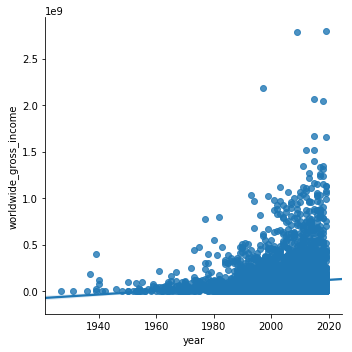

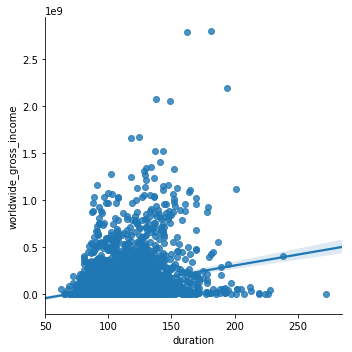

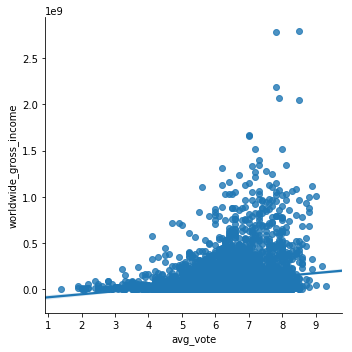

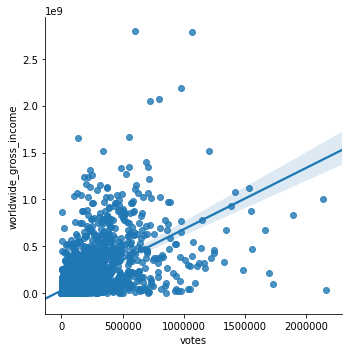

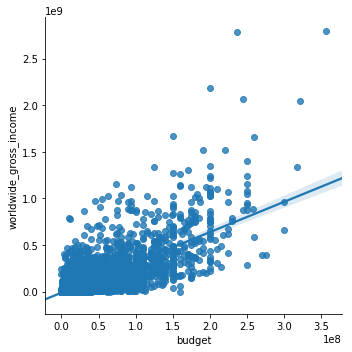

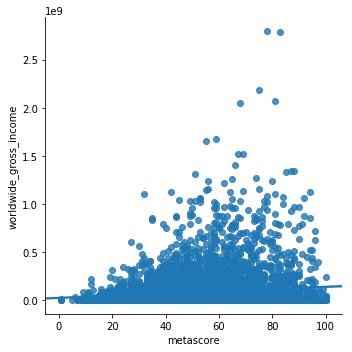

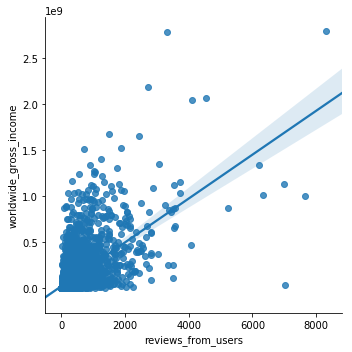

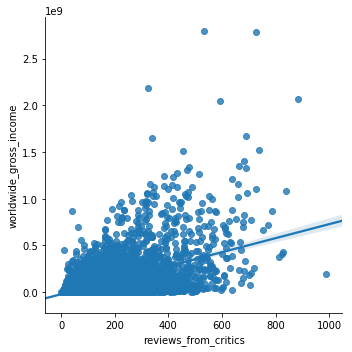

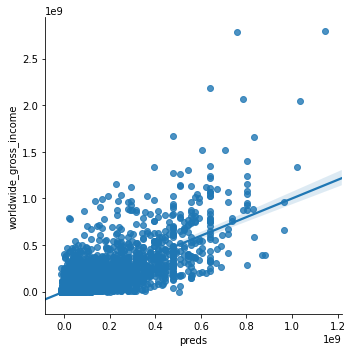

In [40]:
for col in [col for col in cleaned_df.describe().columns if col not in ['usa_gross_income', 'worldwide_gross_income']]:
    sns.lmplot(x=col, y='worldwide_gross_income', data=cleaned_df)
    plt.show();

looks as though budget might be our best predictor of worldwide_gross_income

Build a function that will take in two lists, Y and X, and return the intercept and slope coefficients that minimize SSE.

In [22]:
# taken from GA notes, 3.01 - lab
def lin_reg(x,y):
    # Using other libraries for standard deviation and the Pearson correlation coefficient.
    # Note that in SLR, the correlation coefficient multiplied by the standard
    # deviation of y divided by standard deviation of x is the optimal slope.
    beta_1 = (scipy.stats.pearsonr(x,y)[0])*(np.std(y)/np.std(x))
    
    # The Pearson correlation coefficient returns a tuple, so it needs to be sliced/indexed.
    # The optimal beta is found by: mean(y) - b1 * mean(x).
    beta_0 = np.mean(y)-(beta_1*np.mean(x)) 
    
    return beta_0, beta_1

In [23]:
lin_reg(cleaned_df['budget'].values, cleaned_df['worldwide_gross_income'].values)

(-10821435.630595699, 3.250387742370372)

This means a SLR (simple linear regression) using budget as the sole predictor for worldwide_gross_income would say that the Y intercept is -10,821,435 and slope of 3.25. One way to interpret this would be to say for every 1 dollar increase in budget, the worldwide_gross_income would also increase by 3.25 dollars
___
using this simple model let's calculate and plot the residuals

In [24]:
y_intercept, slope = lin_reg(cleaned_df['budget'].values, cleaned_df['worldwide_gross_income'].values)

# simple y = mx + b to make predictions
y_pred = cleaned_df['budget'].values * slope + y_intercept

# residuals are how far off our predictions really are
resids = abs(cleaned_df['worldwide_gross_income'].values - y_pred)
resids.mean()

59682256.528910674

The average of our residuals means that, on average, our predictions are off by about $59,682,256

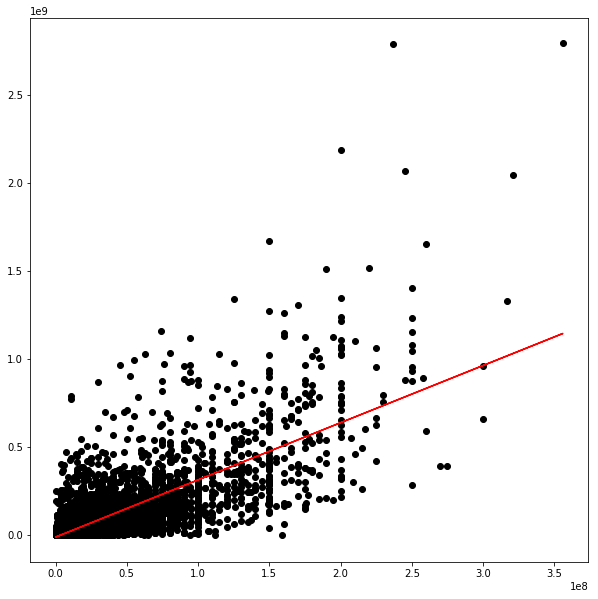

In [25]:
cleaned_df['preds'] = y_pred

# plot our predictions compared to the actuals
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

ax.scatter(x=df['budget'], y=cleaned_df['worldwide_gross_income'], c='k')
ax.plot(df['budget'].values, cleaned_df['preds'].values, color='r')

plt.show()

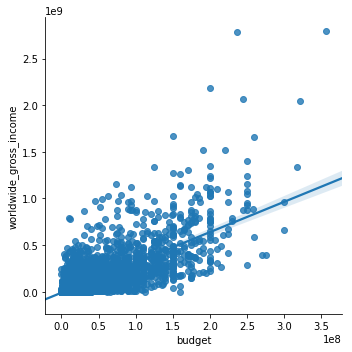

In [26]:
# same plot done with seaborn
sns.lmplot(x='budget', y='worldwide_gross_income', data=cleaned_df);

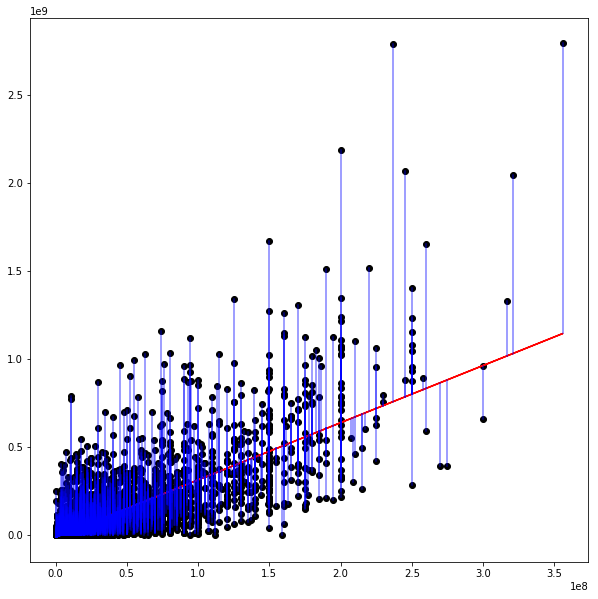

In [29]:
# plot our residuals
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

ax.scatter(x=cleaned_df['budget'], y=cleaned_df['worldwide_gross_income'], c='k')
ax.plot(cleaned_df['budget'].values, cleaned_df['preds'].values, color='r')

for _, row in cleaned_df.iterrows():
    plt.plot((row['budget'], row['budget']), (row['worldwide_gross_income'], row['preds']), 'b-', alpha=.5)

We can see from our residuals that our predictions are getting more and more off the farther out we go.

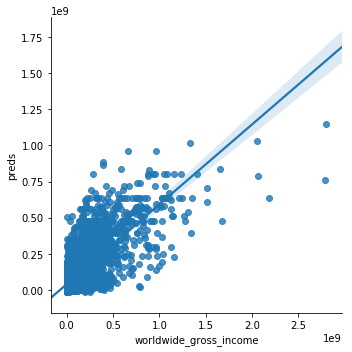

In [28]:
sns.lmplot(x='worldwide_gross_income', y='preds', data=cleaned_df);

this plot is showing us that our SLR model is under-shooting the worldwide_gross_income of movies with very high worldwide gross
___
### Linear Regression

In [30]:
# starting with a simple linear regression model
# usa gross

lr_usa_model = LinearRegression() # instatiate model

lr_usa_model.fit(Z_usa_train, y_usa_train) # fit model to training data

lr_usa_preds = lr_usa_model.predict(Z_usa_test) # calculate predictions based from our model

r2_score(y_usa_test, lr_usa_preds) # evaluate our model using r2 score

0.6202918563082889

an r2 score of 1 means the model is a perfect predictor. So, the closer to 1 our r2 score is the better

In [31]:
# worldwide gross model

lr_ww_model = LinearRegression() # instatiate model

lr_ww_model.fit(Z_ww_train, y_ww_train) # fit model to training data

lr_ww_preds = lr_ww_model.predict(Z_ww_test) # calculate predictions

r2_score(y_ww_test, lr_ww_preds) # evaluate our model using r2 score

0.6344964860635035

___
### Ridge

In [32]:
ridge_usa_model = Ridge(alpha=10) # instatiate model. alpha is our penalty term

ridge_usa_model.fit(Z_usa_train, y_usa_train) # fit ridge to training data

print(f'Training score: {ridge_usa_model.score(Z_usa_train, y_usa_train)}')
print(f'Testing score: {ridge_usa_model.score(Z_usa_test, y_usa_test)}')

Training score: 0.9999997548773197
Testing score: 0.6203347705780454


These two scores tell us that our model is very overfit to our training data. From here we can search over a number of alpha scores to find the best alpha using RidgeCV

In [41]:
r_alphas = np.logspace(-15, -12, 10) # this creates a list of 10 numbers between 10e-12 and 10e-11

# cross validating our list of r_alphas
ridge_usa_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=3)

# fit model using the best alpha
ridge_usa_model = ridge_usa_model.fit(Z_usa_train, y_usa_train)

/Users/Creighton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/Creighton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/Creighton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/Creighton/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/C

In [42]:
ridge_usa_model.alpha_ # our most optimal alpha

1e-12

In [43]:
print(f'Training score: {ridge_usa_model.score(Z_usa_train, y_usa_train)}')
print(f'Testing score: {ridge_usa_model.score(Z_usa_test, y_usa_test)}')

Training score: 1.0
Testing score: 0.6203974289654615


___
### Lasso

In [36]:
# simple Linear Regression for comparison
lm = LinearRegression()
lm.fit(Z_usa_train, y_usa_train)
lm.score(Z_usa_test, y_usa_test)

0.6202918563082889

In [37]:
l_alphas = np.logspace(-11,-9,50) # instatiate alphas to check

lasso_model = LassoCV(alphas=l_alphas, cv=5, max_iter=5000) # Cross validate over our alphas to find most optimal

lasso_model = lasso_model.fit(Z_usa_train, y_usa_train) # fit model using best alpha

In [38]:
lasso_model.alpha_

1e-11

In [39]:
print(f'Training score: {lasso_model.score(Z_usa_train, y_usa_train)}')
print(f'Testing score: {lasso_model.score(Z_usa_test, y_usa_test)}')

Training score: 0.999999999999531
Testing score: -0.17792341762704056
